Import Libraries and Define Constants

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2  # OpenCV
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
NUM_CLASSES = 16  # Assuming you have 15 different cat breeds
NUM_EPOCHS = 2

Establish Path to Directories

In [3]:
data_dir = 'CatBreeds/Gano-Cat-Breeds-V1_1'
preprocessed_dir = 'catbreeds-preprocessed-vj'
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The directory '{data_dir}' does not exist.")

Load Pre-Trained Haar Cascade

In [4]:
cat_face_cascade = cv2.CascadeClassifier('haarcascade_frontalcatface_extended.xml')

Crop the Data with Viola-Jones and Haar-Like features

In [5]:
def preprocess_images_vj(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Get the total number of images to preprocess
    total_images = sum(len(files) for _, _, files in os.walk(input_dir))
    
    with tqdm(total=total_images, desc='Preprocessing Images') as pbar:
        for label in os.listdir(input_dir):
            label_dir = os.path.join(input_dir, label)
            output_label_dir = os.path.join(output_dir, label)
            if not os.path.exists(output_label_dir):
                os.makedirs(output_label_dir)
            for filename in os.listdir(label_dir):
                input_path = os.path.join(label_dir, filename)
                img = cv2.imread(input_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                cat_faces = cat_face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                if len(cat_faces) > 0:
                    x, y, w, h = cat_faces[0]
                    face_img = img[y:y+h, x:x+w]
                    output_path = os.path.join(output_label_dir, filename)
                    cv2.imwrite(output_path, face_img)
                pbar.update(1)  # Update the loading bar

In [6]:
preprocess_images_vj(data_dir, preprocessed_dir)

Preprocessing Images: 100%|██████████| 5625/5625 [05:04<00:00, 18.49it/s]


Map labels to indeces

In [7]:
label_to_index = {label: idx for idx, label in enumerate(os.listdir(data_dir))}

Define the actual dataset

In [8]:
class PreprocessedCatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            label_index = label_to_index[label]  # Convert label to index
            for filename in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, filename))
                self.labels.append(label_index)  # Append the label index

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

Augment Data Further

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Assuming RGB images
])

In [10]:
preprocessed_dataset = PreprocessedCatDataset(root_dir=preprocessed_dir, transform=train_transform)

Create Training and Validation Sets

In [11]:
train_indices, val_indices = train_test_split(np.arange(len(preprocessed_dataset)), test_size=0.2, random_state=42)
train_loader = DataLoader(preprocessed_dataset, batch_size=BATCH_SIZE, sampler=torch.utils.data.SubsetRandomSampler(train_indices))
val_loader = DataLoader(preprocessed_dataset, batch_size=BATCH_SIZE, sampler=torch.utils.data.SubsetRandomSampler(val_indices))

print("Train Dataset size:", len(train_indices))
print("Validation Dataset size:", len(val_indices))

Train Dataset size: 1652
Validation Dataset size: 414


Construct the CNN

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, NUM_CLASSES)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 128 * 8 * 8)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
           Dropout-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
         MaxPool2d-5           [-1, 64, 16, 16]               0
           Dropout-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
         MaxPool2d-8            [-1, 128, 8, 8]               0
           Dropout-9            [-1, 128, 8, 8]               0
           Linear-10                  [-1, 128]       1,048,704
           Linear-11                   [-1, 16]           2,064
Total params: 1,144,016
Trainable params: 1,144,016
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forw

Begin Training and Record Metrics

In [13]:
# Define function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

# Define function to calculate precision
def calculate_precision(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    true_positives = ((predicted == 1) & (labels == 1)).sum().item()
    false_positives = ((predicted == 1) & (labels == 0)).sum().item()
    precision = true_positives / (true_positives + false_positives)
    return precision

# Define function to calculate recall
def calculate_recall(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    true_positives = ((predicted == 1) & (labels == 1)).sum().item()
    false_negatives = ((predicted == 0) & (labels == 1)).sum().item()
    recall = true_positives / (true_positives + false_negatives)
    return recall

# Define function to calculate false positives and false negatives
def calculate_false_predictions(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    false_positives = ((predicted == 1) & (labels == 0)).sum().item()
    false_negatives = ((predicted == 0) & (labels == 1)).sum().item()
    return false_positives, false_negatives

In [14]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
#Initialize Arrays to keep track of metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_false_positives = []
train_false_negatives = []
val_false_positives = []
val_false_negatives = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    train_false_positives_epoch = 0
    train_false_negatives_epoch = 0
    true_positives_epoch = 0
    false_positives_epoch = 0
    false_negatives_epoch = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        false_positives, false_negatives = calculate_false_predictions(outputs, labels)
        train_false_positives_epoch += false_positives
        train_false_negatives_epoch += false_negatives
        true_positives_epoch += ((predicted == 1) & (labels == 1)).sum().item()
        false_positives_epoch += ((predicted == 1) & (labels == 0)).sum().item()
        false_negatives_epoch += ((predicted == 0) & (labels == 1)).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_precision = true_positives_epoch / (true_positives_epoch + false_positives_epoch + 1e-10)  # to avoid division by zero
    train_recall = true_positives_epoch / (true_positives_epoch + false_negatives_epoch + 1e-10)  # to avoid division by zero

    # Append false positives and false negatives
    train_false_positives.append(train_false_positives_epoch)
    train_false_negatives.append(train_false_negatives_epoch)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_total = 0
    val_correct = 0
    val_false_positives_epoch = 0
    val_false_negatives_epoch = 0
    val_true_positives_epoch = 0
    val_false_positives_epoch = 0
    val_false_negatives_epoch = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            val_total += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            false_positives, false_negatives = calculate_false_predictions(outputs, labels)
            val_false_positives_epoch += false_positives
            val_false_negatives_epoch += false_negatives
            val_true_positives_epoch += ((predicted == 1) & (labels == 1)).sum().item()
            val_false_positives_epoch += ((predicted == 1) & (labels == 0)).sum().item()
            val_false_negatives_epoch += ((predicted == 0) & (labels == 1)).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_precision = val_true_positives_epoch / (val_true_positives_epoch + val_false_positives_epoch + 1e-10)  # to avoid division by zero
    val_recall = val_true_positives_epoch / (val_true_positives_epoch + val_false_negatives_epoch + 1e-10)  # to avoid division by zero

    # Append false positives and false negatives
    val_false_positives.append(val_false_positives_epoch)
    val_false_negatives.append(val_false_negatives_epoch)

    # Print and store metrics
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, '
          f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, '
          f'Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

print("Finished training")

# Save the trained model
torch.save(model.state_dict(), 'catModelsVJ.pth')

Epoch 1/2: Train Loss: 2.5639, Train Acc: 0.1253, Val Loss: 2.3275, Val Acc: 0.1836, Train Precision: 0.4545, Train Recall: 0.8333, Val Precision: 0.0000, Val Recall: 0.0000
Epoch 2/2: Train Loss: 2.1403, Train Acc: 0.2494, Val Loss: 2.0846, Val Acc: 0.2754, Train Precision: 0.3571, Train Recall: 0.2381, Val Precision: 0.3333, Val Recall: 0.0667
Finished training


Plot Metrics

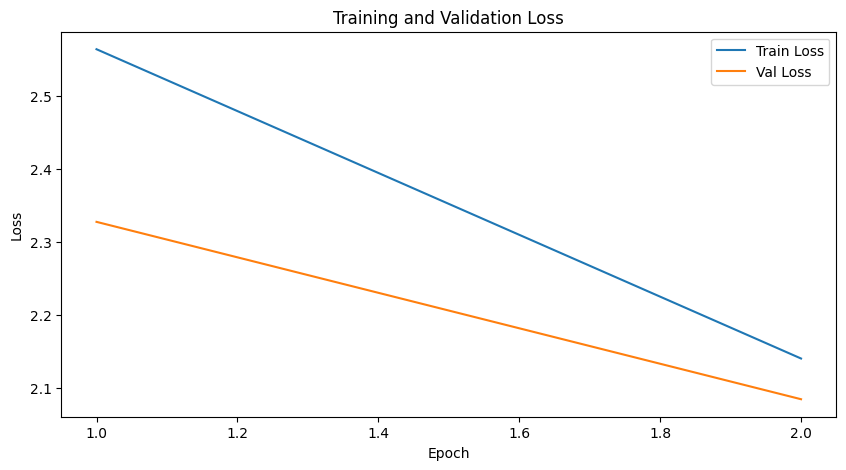

In [16]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


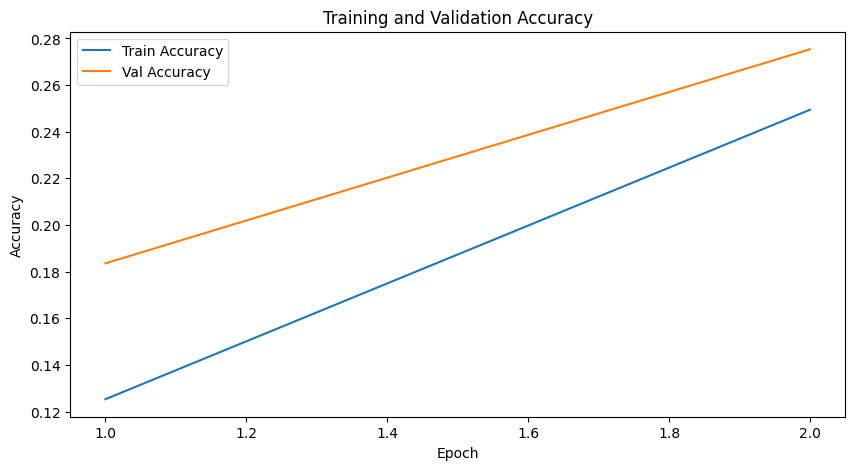

In [17]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

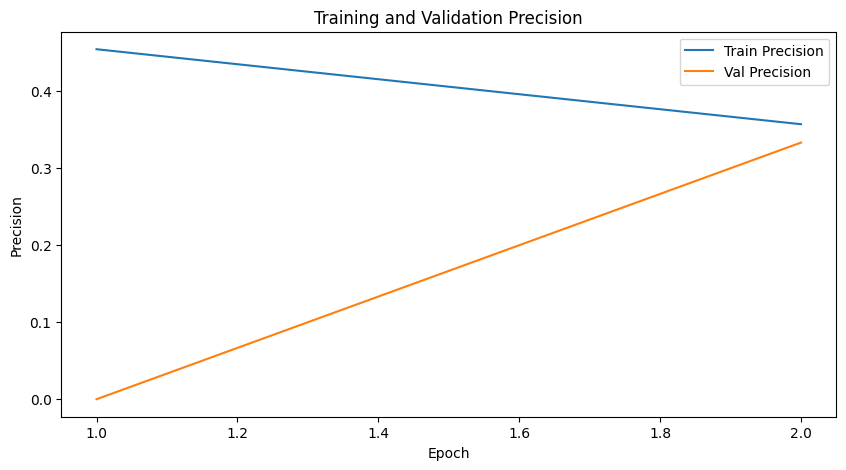

In [18]:
# Plot training and validation precision
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_precisions, label='Train Precision')
plt.plot(range(1, NUM_EPOCHS + 1), val_precisions, label='Val Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.show()

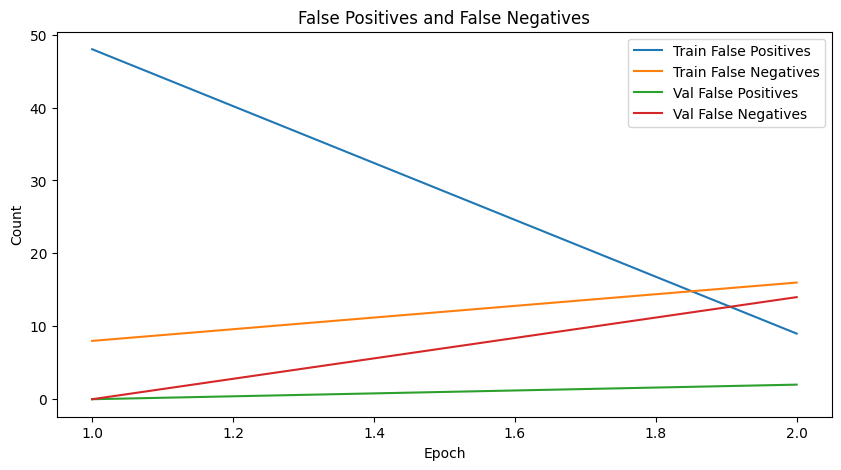

In [19]:
# Plot false positives and false negatives
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_false_positives, label='Train False Positives')
plt.plot(range(1, NUM_EPOCHS + 1), train_false_negatives, label='Train False Negatives')
plt.plot(range(1, NUM_EPOCHS + 1), val_false_positives, label='Val False Positives')
plt.plot(range(1, NUM_EPOCHS + 1), val_false_negatives, label='Val False Negatives')
plt.xlabel('Epoch')
plt.ylabel('Count')
plt.title('False Positives and False Negatives')
plt.legend()
plt.show()

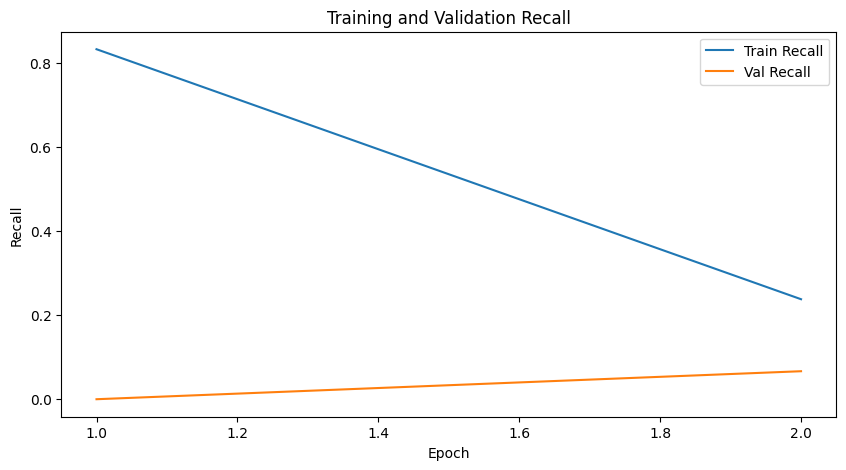

In [20]:
# Plot training and validation recall
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_recalls, label='Train Recall')
plt.plot(range(1, NUM_EPOCHS + 1), val_recalls, label='Val Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.show()

Load the Model for Testing

In [21]:
model = CNN()
model.load_state_dict(torch.load('catModelsVJ.pth'))
model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
)

Actually test on input test.jpg

In [22]:
def predict_breed(image_path):
    # Load and preprocess the test image
    img = Image.open(image_path).convert('RGB')
    img_copy = img.copy()  # Create a copy of the original image
    
    # Convert image to grayscale for face detection
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    
    # Detect cat faces
    cat_faces = cat_face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    # If faces are detected, draw rectangles around them and display the images
    if len(cat_faces) > 0:
        for (x, y, w, h) in cat_faces:
            cv2.rectangle(np.array(img_copy), (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        # Save the test image with detected faces
        cv2.imwrite('output_image.jpg', img_copy)
        print("Saved cropped image as output_image.jpg")

        # Preprocess the image for the model
        img_tensor = train_transform(img_copy).unsqueeze(0)  # Add batch dimension
        
        # Forward pass through the model
        output = model(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    
        # Map predicted index to breed label
        index_to_label = {v: k for k, v in label_to_index.items()}
        predicted_breed = index_to_label[predicted_class.item()]
    else:
        print("No cat faces detected. Using original image instead.")
        # Preprocess the image for the model
        img_tensor = train_transform(img).unsqueeze(0)  # Add batch dimension
        
        # Forward pass through the model
        output = model(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
    
        # Map predicted index to breed label
        index_to_label = {v: k for k, v in label_to_index.items()}
        predicted_breed = index_to_label[predicted_class.item()]
    
    return predicted_breed, confidence.item()


In [23]:
# Test image path
test_image_path = 'test.jpg'

# Predict breed of the test image with confidence level
prediction, confidence = predict_breed(test_image_path)
print(f"Predicted breed: {prediction}, Confidence: {confidence * 100}%")

No cat faces detected. Using original image instead.
Predicted breed: Bombay, Confidence: 24.034324288368225%
